In [1]:
loginInfo = ['dev_angel', 'lwdev', 'DEV_TEST', 'PREPROD_CDB_PREPROD_9593B140CA75F1259DD584236657F2A996A6FA2A14B603FF', 'GRAPH_INTERNAL', 'L@cework809!']
theSource = "datacollectorr"
theDest = "amazonawscom0443TCP"
hoursTable = "test_angel_hours_range"
fromDate = "'01/01/2019 12:00:00'"
toDate = "'05/31/2019 12:00:00'"

query = "select ZEROIFNULL(NUM_CONNS) from %s left" \
        " join (SELECT to_timestamp_ntz(ns.start_time) as startTime, CONCAT(split_part(ns.props:exe_path, '/', -1),'',ns.props:cmdline_terms[0]) as sourceApplication,  CONCAT(split_part(nd.key:hostname, '.', -2), split_part(nd.key:hostname, '.', -1), nd.key:ip_internal, nd.key:port, nd.key:protocol) as destinationDNS,  sum(edge_t.props:num_conns) num_conns  FROM GRAPH_INTERNAL.edge_t, GRAPH_INTERNAL.node_t ns, GRAPH_INTERNAL.node_t nd  WHERE edge_t.SRC_KEY = ns.KEY AND edge_t.DST_KEY = nd.KEY and edge_t.start_time = ns.start_time  and edge_t.start_time = nd.start_time   AND edge_t.start_time > to_timestamp(%s) AND edge_t.start_time < to_timestamp(%s) AND ns.start_time > to_timestamp(%s) AND ns.start_time < to_timestamp(%s) AND nd.start_time > to_timestamp(%s) AND nd.start_time < to_timestamp(%s) AND edge_t.SRC_TYPE = 'Process' AND edge_t.DST_TYPE = 'DnsSep'  group by startTime, sourceApplication, destinationDNS) as t" \
        " on %s.TIME = t.STARTTIME" \
        " and t.sourceApplication like '%s'" \
        " and t.destinationDns = '%s'" \
        " order by test_angel_hours_range.TIME;" %(hoursTable, fromDate, toDate, fromDate, toDate, fromDate, toDate, hoursTable, theSource, theDest)

In [2]:
import pandas as pd, sys, snowflake.connector

def dataImporter(query,loginInfo):
  
    # Get the other login info etc. from the command line.
    loginParams = ['user','account','warehouse','database','schema','password']
    
    if all(param in loginInfo for param in loginParams) and isinstance(loginInfo,dict):
        USER = loginInfo['user']
        ACCOUNT = loginInfo['account']
        WAREHOUSE = loginInfo['warehouse']
        DATABASE = loginInfo['database']
        SCHEMA = loginInfo['schema']
        PASSWORD = loginInfo['password']

    elif isinstance(loginInfo,list) and len(loginInfo)==6:
        USER = loginInfo[0]
        ACCOUNT = loginInfo[1]
        WAREHOUSE = loginInfo[2]
        DATABASE = loginInfo[3]
        SCHEMA = loginInfo[4]
        PASSWORD = loginInfo[5]

    else:
        print("\nError: You must either pass the params\n   ", loginParams, "\nas the dict loginInfo or IN ORDER as a list or IN ORDER as command-line arguments.")
        print("\nCheck that your keys match case as the above if using the dict.")
        sys.exit(-1)

    con = snowflake.connector.connect(
        user=USER,
        password=PASSWORD,
        account=ACCOUNT,
        warehouse=WAREHOUSE,
        database=DATABASE,
        schema=SCHEMA
    )
    cursor = con.cursor()
    try:
        cursor.execute(query);
        df = pd.DataFrame.from_records(iter(cursor), columns=[x[0] for x in cursor.description])
        return df
    finally:
        cursor.close()

In [3]:
result = dataImporter(query, loginInfo)
dbRep = []
for index, row in result.iterrows():
    for j, column in row.iteritems():
        dbRep.append(int(column))
time_series = dbRep

In [4]:
import math
import numpy as np

time_series_expected = []
decayFunction_values = []

class Algorithm():
    
    # Initialized with the Timeserie
    def __init__(self): 
        self.hyperparam = None
        self.reset()
        time_series_expected = []
        self.cumulativeValues = []
        self.previousExpected = 0

    # Polynomial regressions (polynomial least squares fittings).
    def decayFunction(self, TSLRE):
        return (-0.04448 * (TSLRE/24)) + 3.6 # Generalize better than order 2


    def secondDecayFunction(self, lastTick, value): 
        return abs(lastTick - value) 
    
    def reset(s):
        s.meanSinceLastRareEdge = 0
        s.stdSinceLastRareEdge = 0
        s.timeSinceLastRareEdge = 0
        s.expectedValue = 0
        
    currentHour = -1 #0 in first iteration
    trainingTime = 30 * 24
    
    # Cumulative values since Last Rare Edge
    lastMaxValue = 0
    lastMaxValuePosition = 0
    lastTick = 0 # Test
    lastReportedRareEdge = 0
    
    
    def feed(s, tick):
        
        s.cumulativeValues.append(tick)
        avg = np.mean(s.cumulativeValues[-24:])
        std = np.std(s.cumulativeValues[-200:])
        
        # Training first 30 days
        s.currentHour = s.currentHour + 1
        if s.currentHour < s.trainingTime:
            s.lastMaxValue = max(s.lastMaxValue, tick)
            time_series_expected.append(0) #UI
            return
        
        elif s.currentHour == s.trainingTime:
            
            s.lastMaxValue = max(s.lastMaxValue, tick)
            s.lastMaxValuePosition = s.trainingTime
            s.expectedValue =   (s.decayFunction(1) * s.lastMaxValue) ## working ?
            s.previousExpected =  s.expectedValue  
            time_series_expected.append(s.expectedValue) #UI
            return
      
        #Time Since Last Rare Edge
        TSLMV = s.currentHour - s.lastMaxValuePosition
        TSLRE =  s.currentHour - s.lastReportedRareEdge
        
        if tick > s.expectedValue:
            if (TSLRE > 24):
                print("Hour: ",s.currentHour," ----> Value: ", int(tick))
                lastReportedRareEdge = s.currentHour
             
        if (s.decayFunction(TSLMV) * s.lastMaxValue) < s.decayFunction(1) * tick:
            s.expectedValue = s.decayFunction(1) * tick
            s.expectedValue = s.expectedValue +  std
            s.lastMaxValuePosition = s.currentHour
            s.lastMaxValue = tick
        else:
            s.expectedValue = s.decayFunction(TSLMV) * s.lastMaxValue 
            s.expectedValue = s.expectedValue + std 
            
        time_series_expected.append(s.expectedValue)
            

In [5]:
algoInstance = Algorithm()
for entry in time_series:
    algoInstance.feed(entry)

/Users/anglecambero/anaconda3/lib/python3.7/site-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


Text(0.5, 1.0, 'Plot of the number of connections between processes and dns by day')

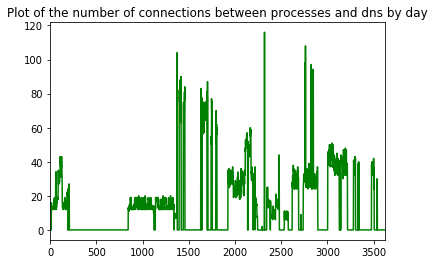

In [9]:
import seaborn as sns
import matplotlib.pyplot as plot
sns.tsplot(time_series, color="green")
plot.title("Plot of the number of connections between processes and dns by day") 

/Users/anglecambero/anaconda3/lib/python3.7/site-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


Text(0.5, 1.0, '----------------------------------')

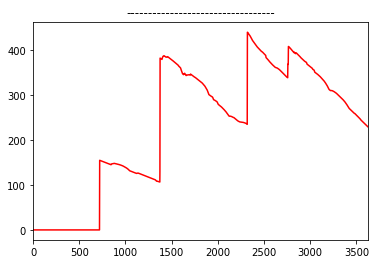

In [7]:
sns.tsplot(time_series_expected, color="red")
plot.title("----------------------------------") 

In [8]:
# sns.tsplot(decayFunction_values, color="blue")
# plot.title("----------------------------------") 